In [1]:
import pandas as pd
import quantstats as qs
import numpy as np
import talib
import ray
import random 

from core.system import *
from core.operation import *
from fredapi import Fred
from pandas.tseries.offsets import BDay

import warnings

warnings.filterwarnings('ignore')

### Data

In [2]:
def create_multi_index(factor_data, stock):
    factor_values = pd.concat([factor_data] * len(stock), ignore_index=True).values
    multi_index = pd.MultiIndex.from_product([stock, factor_data.index])
    multi_index_factor = pd.DataFrame(factor_values, columns=factor_data.columns, index=multi_index)
    multi_index_factor.index = multi_index_factor.index.set_names(['permno', 'date'])
    return multi_index_factor

In [3]:
live = True
start = '2005-01-01'
current_date = date.today().strftime('%Y-%m-%d')
window = 252
threshold = 2_000_000_000
hold_period = 21
stock = read_stock(get_large(live) / 'permno_live.csv')

In [4]:
rf = pd.read_parquet(get_parquet(live) / 'data_rf.parquet.brotli')
rf = rf.ffill()
rf = create_multi_index(rf, stock)
cap = pd.read_parquet(get_parquet(live) / 'data_misc.parquet.brotli', columns=['market_cap'])
price_data = pd.read_parquet(get_parquet(live) / 'data_price.parquet.brotli')

In [5]:
price_data = price_data.merge(rf, left_index=True, right_index=True, how='left')
price_data = price_data.merge(cap, left_index=True, right_index=True, how='left')
price_data['RF'] = price_data.groupby('permno')['RF'].ffill()

### Create Metrics

In [6]:
def compound_returns(x, window):
    return (1 + x).rolling(window).apply(lambda y: y.prod(), raw=True) - 1

### Test Monthly

In [37]:
num_stocks = 25
lookback = 12

In [38]:
monthly_data = set_length(price_data, 18) # 575 tickers
permno_list = monthly_data.index.get_level_values('permno').unique()
permno_random = random.sample(list(permno_list), num_stocks)
monthly_data = get_stocks_data(monthly_data, permno_random)

In [39]:
monthly_data = monthly_data.reset_index(level=0).groupby('permno').resample('M').last().drop('permno', axis=1)

In [40]:
monthly_data = create_return(monthly_data, [1])
monthly_data['com_ret'] =  monthly_data.groupby('permno')['RET_01'].transform(compound_returns, lookback)
monthly_data['com_ret_excess'] = monthly_data['com_ret'] - monthly_data['RF']

#### Get Select Stock Data

In [41]:
monthly_data = monthly_data[['RET_01', 'com_ret_excess']]
monthly_data = monthly_data.dropna()

#### Strategy

In [42]:
monthly_data['shift_ret'] = monthly_data.groupby('permno')['RET_01'].shift(-1)

In [43]:
monthly_data['sign'] = np.where(monthly_data['com_ret_excess'] >= 0, 1, -1)

In [44]:
monthly_data['total_ret'] = monthly_data['shift_ret'] * monthly_data['sign'] * (1/num_stocks)

In [45]:
total_ret = monthly_data.groupby('date')['total_ret'].sum()

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2006-02-28   2006-02-28
End Period                 2024-01-31   2024-01-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          270.71%      -28.27%
CAGR﹪                     5.17%        -1.27%

Sharpe                     2.41         -0.3
Prob. Sharpe Ratio         98.26%       39.17%
Smart Sharpe               2.1          -0.26
Sortino                    3.46         -0.4
Smart Sortino              3.03         -0.35
Sortino/√2                 2.45         -0.28
Smart Sortino/√2           2.14         -0.24
Omega                      0.95         0.95

Max Drawdown               -54.35%      -57.26%
Longest DD Days            1918         5451
Volatility (ann.)          75.81%       62.99%
R^2                        0.0          0.0
Information Ratio          -0.13        -0.13
Calmar       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2009-02-28,2023-12-31,2024-01-31,5451,-57.261407,-57.180381
2,2007-05-31,2008-04-30,2008-04-30,336,-6.720118,-6.031580
3,2006-04-30,2006-08-31,2006-10-31,185,-6.327452,-5.090154
4,2008-06-30,2008-07-31,2008-07-31,32,-3.896028,-2.253583
5,2008-11-30,2008-11-30,2008-11-30,1,-2.146741,NaN


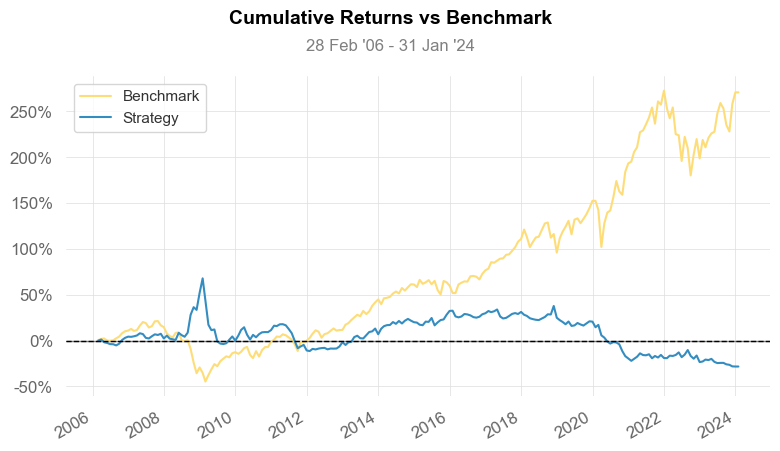

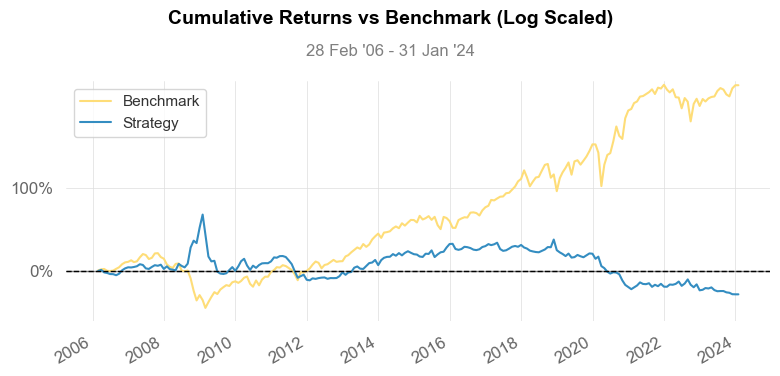

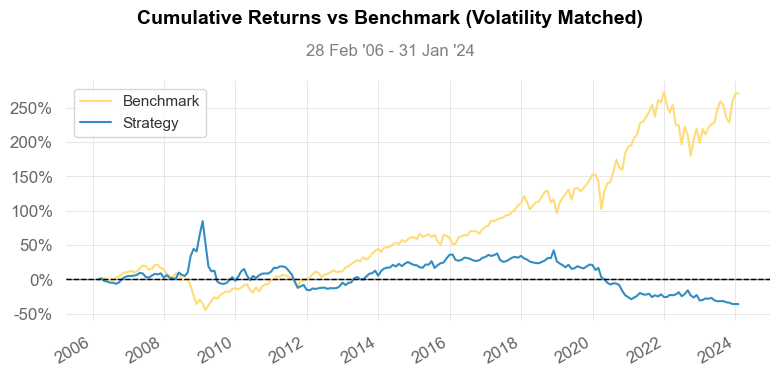

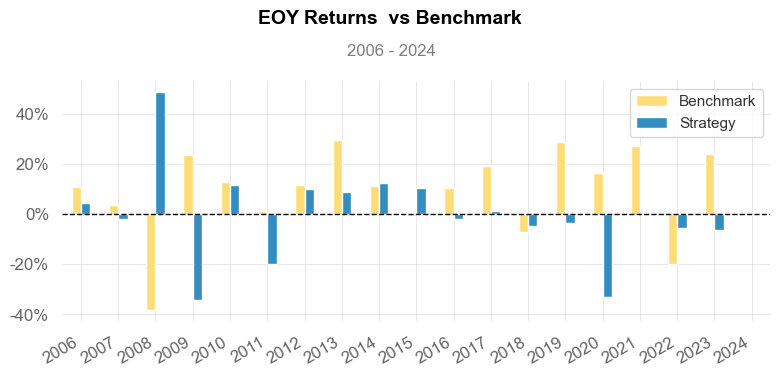

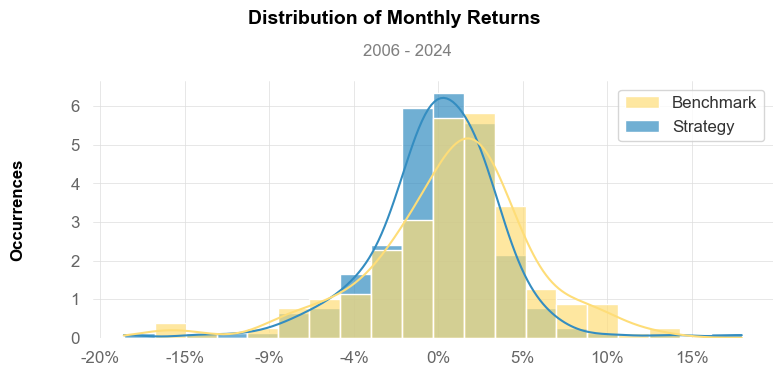

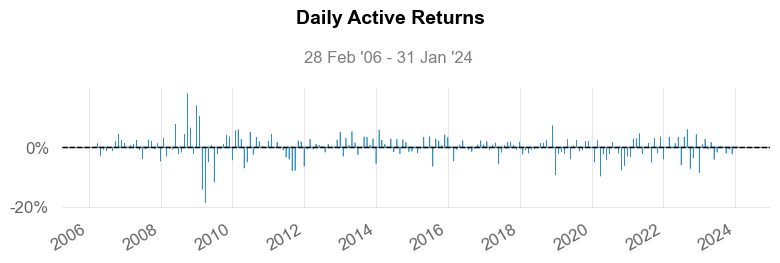

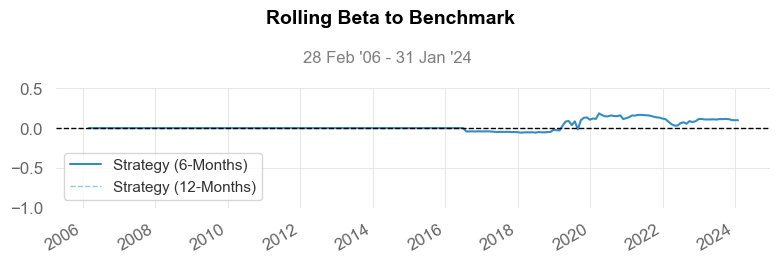

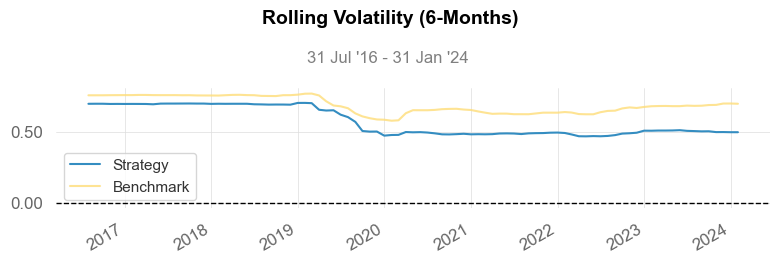

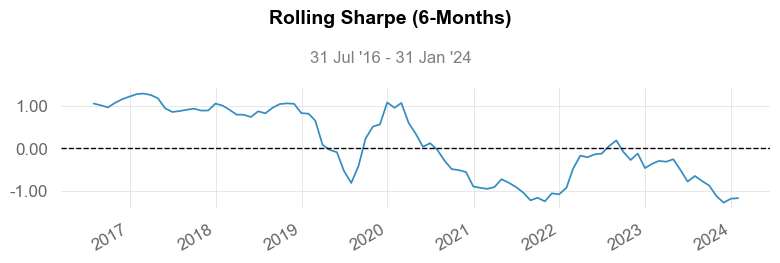

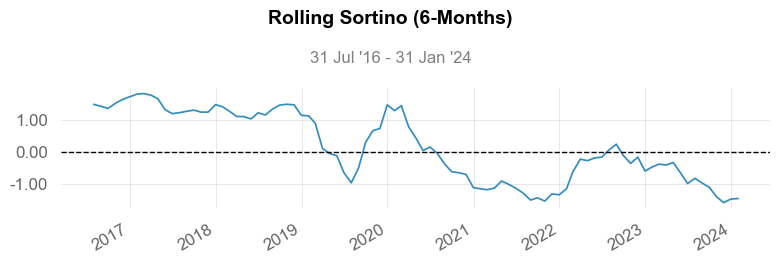

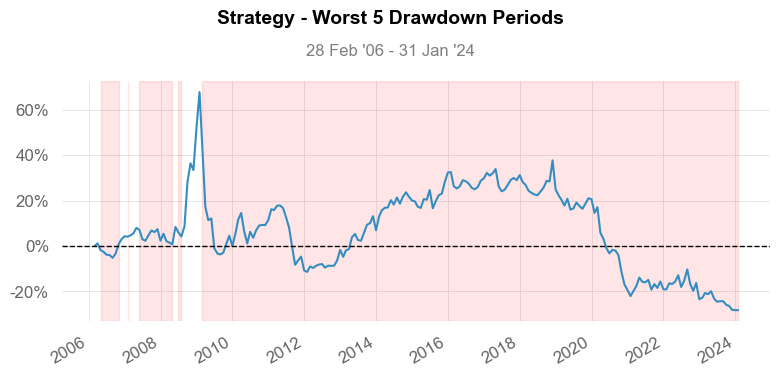

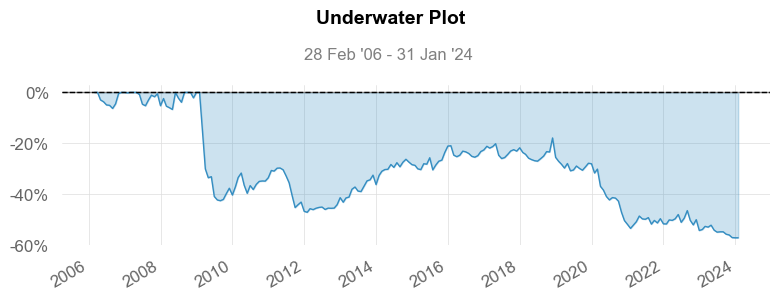

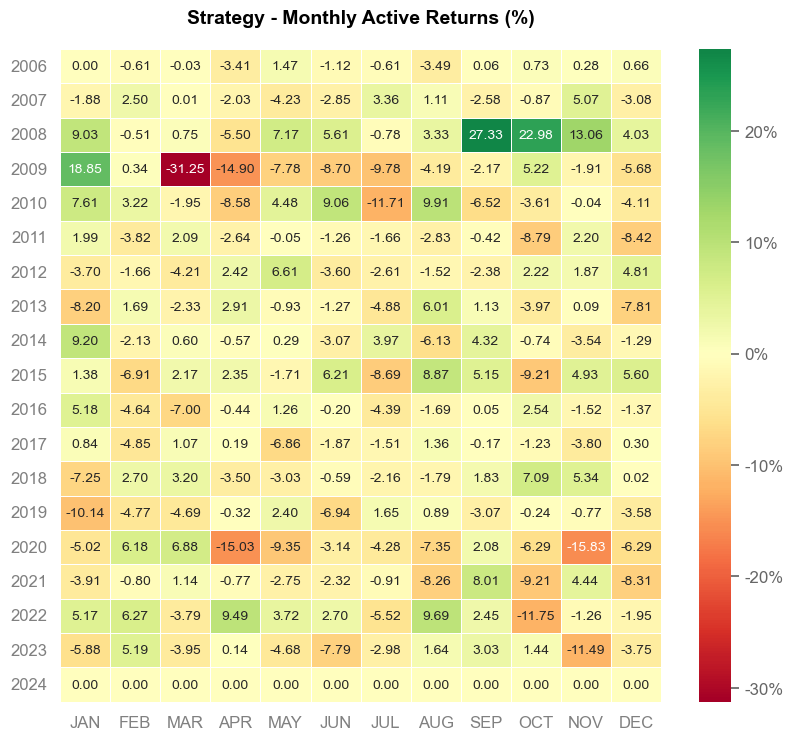

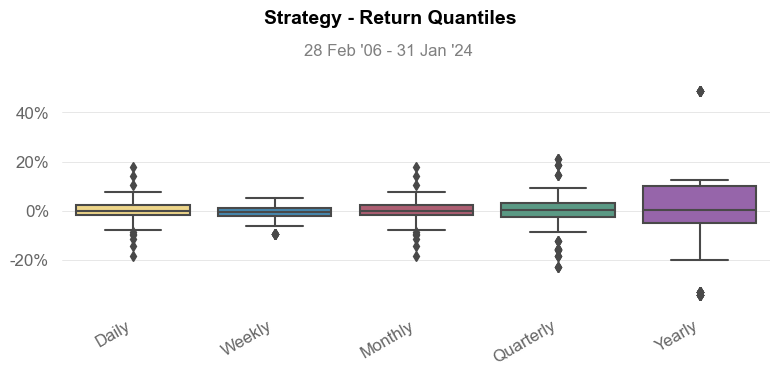

In [46]:
qs.reports.full(total_ret, 'SPY')